In [1]:
# Allows import from parent directory.
import sys; sys.path.append('..')

import os

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import src.visualization_utils as viz
from mpl_toolkits.axes_grid1 import ImageGrid
from src import utils
from src.loaders import DetectionsLoader, FrameLoader, LabelsLoader
from src.models import Vehicle
from src.providentia_utils import match_perspective, parse_perspectives

pio.templates['tight'] = dict(
    layout=dict(
        margin=dict(l=10, r=10, t=10, b=10),
        font=dict(family='charter', color='black', size=14),
    )
)
pio.templates.default = 'plotly_white+tight'


In [2]:
output_dir = 'output/approach'
os.makedirs(output_dir, exist_ok=True)

In [3]:
frame_loader = FrameLoader('../data/r0_a9_dataset/images')
labels_loader = LabelsLoader('../data/r0_a9_dataset/labels_fixed')
detections_loader = DetectionsLoader('../data/detections/r0_a9_dataset/cityscapes_mask_rcnn_R_50_FPN')
perspectives = parse_perspectives('../data/profusion_r0_dataset/r0_s1/05_calibration')

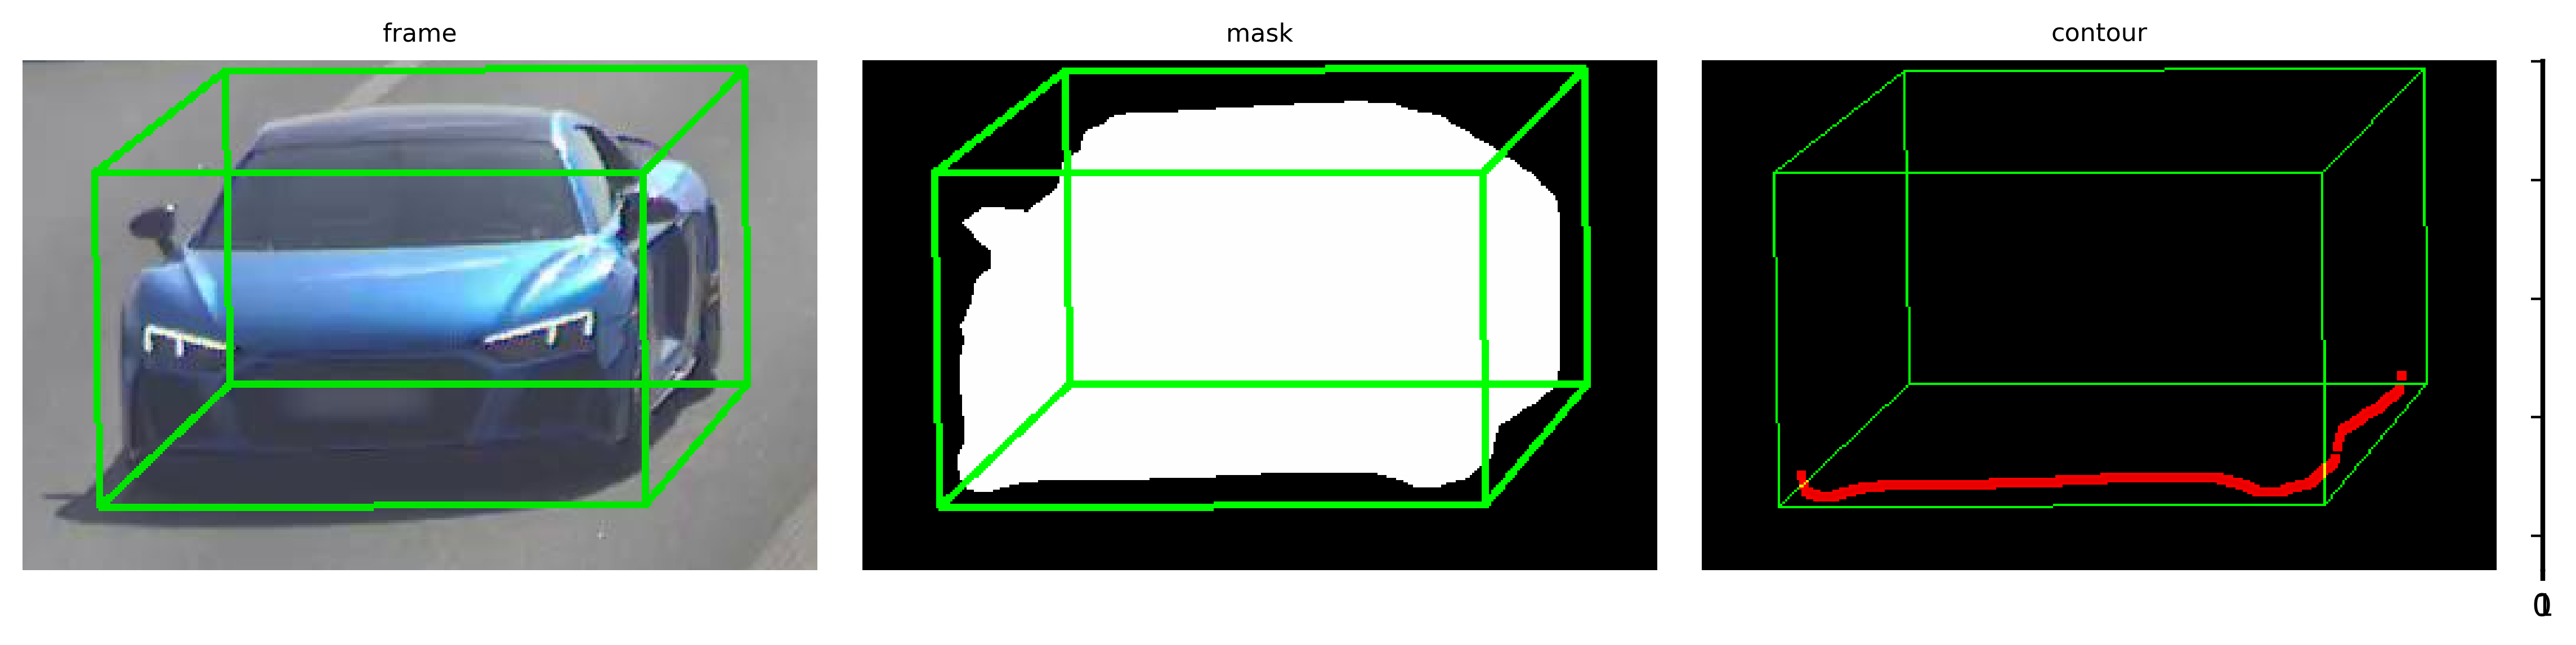

In [4]:
# Bottom contour figures

index = 363
frame = frame_loader.load_item(index)
detections = detections_loader.load_item(index)
labels, labels_data = labels_loader.load_item(index)
perspective = match_perspective(perspectives, labels_data)

for label in labels:
    label.yaw += np.pi

frame = viz.overlay_3d_vehicles(
    frame.copy(), labels, perspective, box_colors=(0, 0.9, 0), draw_direction=False
)

detection = detections[1]
contour = utils.calculate_bottom_contour(detection, False)

black_img = np.zeros_like(frame)

img = frame[710:925, 150:485]

mask_img = viz.overlay_colored_masks(black_img.copy(), detections, colors=(1, 1, 1)) * 2
mask_img = viz.overlay_3d_vehicles(
    mask_img,
    labels,
    perspective,
    box_colors=(0, 1, 0),
    box_thickness=2,
    draw_direction=False,
)
mask_img = mask_img[710:925, 150:485]

contour_img = black_img.copy()
contour_img[contour[1], contour[0]] = (255, 0, 0)
contour_img = contour_img[710:925, 150:485]
contour_img[1:] += contour_img[:-1]
contour_img[:, 1:] += contour_img[:, :-1]
contour_img[1:] += contour_img[:-1]
contour_img[:, 1:] += contour_img[:, :-1]
contour_img[1:] += contour_img[:-1]
contour_img[:, 1:] += contour_img[:, :-1]

bounding_box_overlay = viz.overlay_3d_vehicles(
    np.zeros_like(frame),
    labels,
    perspective,
    box_colors=(0, 1, 0),
    box_thickness=1,
    draw_direction=False,
)
contour_img += bounding_box_overlay[710:925, 150:485]

imgs = [img, mask_img, contour_img]
names = ['frame', 'mask', 'contour']

fig = plt.figure(figsize=(16, 3), dpi=400)
grid = ImageGrid(fig, 111, nrows_ncols=(1, 4), axes_pad=0.2)
for ax, name, img in zip(grid, names, imgs):
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(name, {'fontsize': 8})
plt.show()

for name, img in zip(names, imgs):
    plt.imsave(os.path.join(output_dir, name + '.png'), img)

In [5]:
# 2D hyperplane figure

index = 364
frame = frame_loader.load_item(index)
labels, labels_data = labels_loader.load_item(index)
detections = detections_loader.load_item(index)
perspective = match_perspective(perspectives, labels_data)

plt.imsave(os.path.join(output_dir, 'input.jpg'), frame)

points = np.array([[-500, 400], [0, 0], [0, 0]])
points = perspective.project_to_image(points)
a, b = points.T.astype(int)
img = cv2.line(frame.copy(), (*a,), (*b,), (255, 0, 0), 20)

for label in labels:
    loc = label.location
    loc2 = label.location + np.array([[-np.sign(loc[1, 0]) * 15, 0, 0]]).T
    points = perspective.project_to_image(np.hstack((loc, loc2)))
    a, b = points.T.astype(int)
    img = cv2.arrowedLine(img, (*a,), (*b,), (0, 230, 0), 10, tipLength=0.5)

points = np.array([[200, 200], [0, 10], [0, 0]])
points = perspective.project_to_image(points)
a, b = points.T.astype(int)
img = cv2.arrowedLine(img, (*a,), (*b,), (255, 0, 0), 20)

plt.imsave(os.path.join(output_dir, 'direction.png'), img)

px.imshow(img)

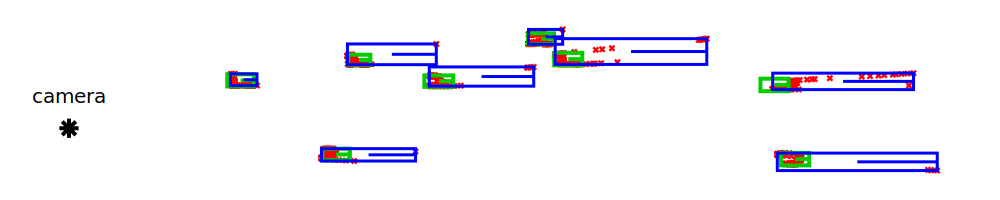

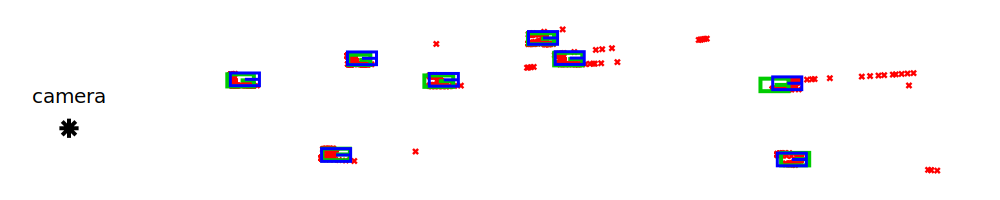

In [16]:
# Birds eye 2D bbox figures

index = 363
frame = frame_loader.load_item(index)
labels, labels_data = labels_loader.load_item(index)
detections = detections_loader.load_item(index)
perspective = match_perspective(perspectives, labels_data)

labels = [labels[i] for i in [0, 3, 5, 2, 6, 8, 17, 15]]
detections = [detections[i] for i in [1, 11, 5, 13, 0, 22, 15, 8]]

ground_contours = []
naive_vehicles = []
vehicles = []
for detection in detections:
    image_contour = utils.calculate_bottom_contour(detection, False)
    ground_contour = perspective.project_to_ground(image_contour)
    ground_contours.append(ground_contour)

    min_x, min_y = ground_contour[:2].min(1)
    max_x, max_y = ground_contour[:2].max(1)

    vehicle = Vehicle(
        np.array([[min_x + max_x, min_y + max_y, 0]]).T / 2,
        (max_x - min_x, max_y - min_y, 0),
        0,
        '',
    )
    naive_vehicles.append(vehicle)

    max_x = min_x + 4.8
    if max_y + min_y > 2 * perspective.translation[1, 0]:
        max_y = min_y + 2.1
    else:
        min_y = max_y - 2.1

    vehicle = Vehicle(
        np.array([[min_x + max_x, min_y + max_y, 0]]).T / 2,
        (max_x - min_x, max_y - min_y, 0),
        0,
        '',
    )
    vehicles.append(vehicle)

perspective.translation[:2] += np.array([[50, 0]]).T


def create_base_figure():
    fig = go.Figure()
    fig.update_yaxes(scaleanchor='x')
    viz.draw_camera_position(fig, perspective)

    viz.draw_vehicles(fig, labels, box_colors=(0, 0.8, 0), box_thickness=4)
    viz.draw_annotations(
        fig,
        perspective.translation[:2] + np.array([[0, 5]]).T,
        ['camera'],
        size=20,
    )

    viz.draw_contours(fig, ground_contours, marker_size=6)

    axis_kwargs = dict(
        showline=False, zeroline=False, showgrid=False, showticklabels=False
    )

    fig.update_layout(
        height=200, width=1000, showlegend=False, xaxis=axis_kwargs, yaxis=axis_kwargs
    )

    return fig


fig = create_base_figure()
viz.draw_vehicles(fig, naive_vehicles, box_colors=(0, 0, 1), box_thickness=3)
fig.write_image(os.path.join(output_dir, 'naive_bbox.pdf'))
fig.show('svg')

fig = create_base_figure()
viz.draw_vehicles(fig, vehicles, box_colors=(0, 0, 1), box_thickness=3)
fig.write_image(os.path.join(output_dir, 'bbox.pdf'))
fig.show('svg')


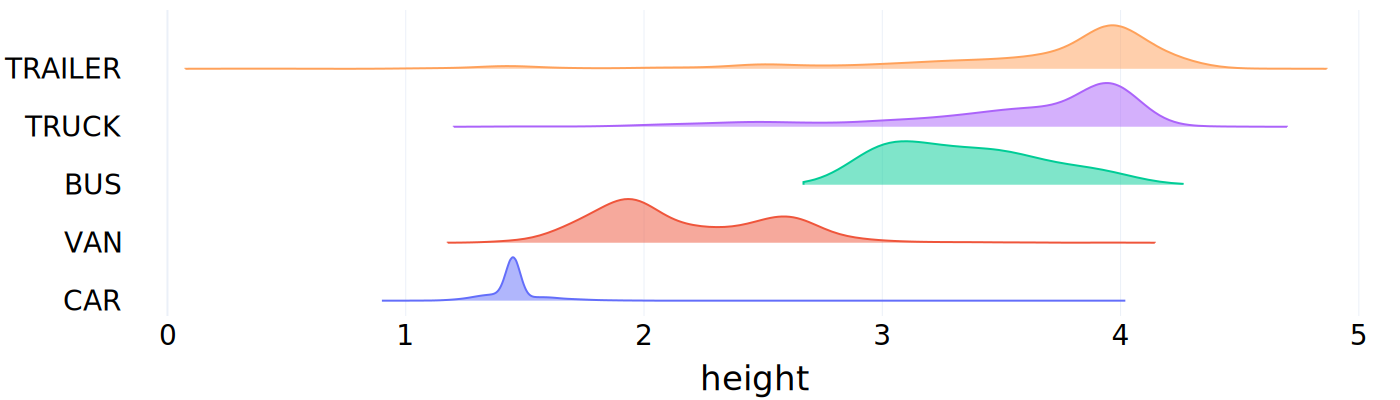

In [7]:
# Height distribution per category figure

data = {'height': [], 'category': []}
for labels, labels_data in labels_loader.load_items():
    for label in labels:
        data['height'].append(label.dimensions[2])
        data['category'].append(label.category)
df = pd.DataFrame(data)

fig = go.Figure()
for i, cat in enumerate(['CAR', 'VAN', 'BUS', 'TRUCK', 'TRAILER']):
    fig.add_trace(go.Violin(x=df[df.category == cat].height, line_color=px.colors.qualitative.Plotly[i], name=cat))

fig.update_traces(orientation='h', side='positive', width=1.5,points=False)
fig.update_layout(
    width=1400,
    height=400,
    font_size=28,
    showlegend=False,
    xaxis_title='height',
)
fig.show('svg')

fig.write_image(os.path.join(output_dir, 'heights.pdf'))